# RSSI Localization Pipeline
This notebook documents the full neural-network + local KNN pipeline used to locate the WiFi probe on the board. Each cell explains how a raw RSSI vector is transformed into an embedding, how the L-KNN votes, and which diagnostics you can read to understand the prediction.

## Prerequisites
- Run `PYTHONPATH=src python -m localization.pipeline ...` at least once to produce `reports/localizer.joblib` and the generated metrics (confusion matrix, JSON report, etc.).
- Work inside the same Python environment (`.venv`) so that the imported modules and dependencies match those used during training.
- Keep the measurement folders `ddeuxmetres/` and `dquatremetres/` available since this notebook loads them directly.
- Glossary of terms used below:
  - **RSSI (Received Signal Strength Indicator)**: WiFi power in dBm reported by the router for each antenna.
  - **Embedding**: compact vector representation produced by the MLP to summarize the RSSI pattern of a cell.
  - **Local KNN (L-KNN)**: distance-weighted K-nearest neighbors operating in the embedding space to predict the cell ID.

## Rappels sur les entrées et la séparation des données
- Les 5 features d'entrée sont strictement RSSI (`Signal`, `Noise`, `signal_A1`, `signal_A2`, `signal_A3`).
- La distance routeur reste une métadonnée pour l'analyse mais **n'est pas injectée** dans le modèle.
- Le pipeline CLI réalise un split stratifié 80/20 sur les index sans chevauchement : les 20% de test ne sont jamais vus pendant l'entraînement.
- Les métriques et artefacts (`latest_metrics.json`, matrices de confusion, etc.) reflètent uniquement ce split de validation.


## Phase 1 - Prepare the tooling

In [1]:

# Import required modules: filesystem helpers, plotting, math utilities, and our local code.
from pathlib import Path
import sys

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, Markdown, Image
from sklearn.decomposition import PCA

plt.style.use('seaborn-v0_8')  # readable styling for plots

# Define important paths: project root, measurement folders, trained model, and the cell layout image.
PROJECT_ROOT = Path('..').resolve()
DATA_FOLDERS = [
    PROJECT_ROOT / 'data' / 'D005' / 'ddeuxmetres',
    PROJECT_ROOT / 'data' / 'D005' / 'dquatremetres',
    PROJECT_ROOT / 'data' / 'E101' / 'dtroismetres',
    PROJECT_ROOT / 'data' / 'E101' / 'dcinqmetres',
]
MODEL_PATH = PROJECT_ROOT / 'reports' / 'localizer.joblib'
GRID_IMAGE_PATH = PROJECT_ROOT / 'gridcellrepresentation.png'

# Allow imports from the local `src/` directory.
sys.path.append(str(PROJECT_ROOT / 'src'))

from localization.data import CampaignSpec, load_measurements, DEFAULT_CELL_WIDTH_M, DEFAULT_CELL_HEIGHT_M
from localization.embedding_knn import EmbeddingKnnLocalizer, _apply_activation

FEATURE_COLUMNS = ["Signal", "Noise", "signal_A1", "signal_A2", "signal_A3"]

print(f"Project root: {PROJECT_ROOT}")
print(f"Expected model path: {MODEL_PATH}")

REPORTS_DIR = PROJECT_ROOT / "reports"
REPORTS_DIR.mkdir(exist_ok=True)


Project root: /home/test/Documents/projetretd
Expected model path: /home/test/Documents/projetretd/reports/localizer.joblib


We configure project paths, add `src/` to `sys.path`, and import the helper modules (`localization.data`, `localization.embedding_knn`). This also defines the RSSI feature list (`FEATURE_COLUMNS`).

## Phase 2 - Load and combine measurements

In [ ]:

# Build the list of campaigns (2 m + 4 m) that are actually present on disk.
campaigns = [CampaignSpec(path) for path in DATA_FOLDERS if path.exists()]
if not campaigns:
    raise RuntimeError("No campaign found. Verify data/D005 and data/E101 folders (ddeuxmetres/dquatremetres/dtroismetres/dcinqmetres).")

# Merge every CSV into a single DataFrame while keeping grid/campaign metadata.
df = load_measurements(campaigns)
print(f"Loaded {len(df)} rows covering {df['grid_cell'].nunique()} cells.")
display(df.head())

# Quick lookup table to retrieve spatial info (grid indices, metric coordinates, campaign name).
cell_lookup = (
    df[["grid_cell", "grid_x", "grid_y", "coord_x_m", "coord_y_m", "campaign"]]
    .drop_duplicates("grid_cell")
    .set_index("grid_cell")
)
GRID_WIDTH_M = df["coord_x_m"].max() + DEFAULT_CELL_WIDTH_M / 2
GRID_HEIGHT_M = df["coord_y_m"].max() + DEFAULT_CELL_HEIGHT_M / 2


Loaded 1700 rows covering 34 cells.


,Signal,Noise,signal_A1,signal_A2,signal_A3,grid_x,grid_y,grid_cell,router_distance_m,campaign,coord_x_m,coord_y_m
0,-37,-95,-38,-43,-48,0,0,0_0,2.0,ddeuxmetres,0.125,0.15
1,-37,-95,-38,-43,-48,0,0,0_0,2.0,ddeuxmetres,0.125,0.15
2,-37,-95,-38,-43,-48,0,0,0_0,2.0,ddeuxmetres,0.125,0.15
3,-37,-95,-38,-43,-48,0,0,0_0,2.0,ddeuxmetres,0.125,0.15
4,-37,-95,-38,-43,-48,0,0,0_0,2.0,ddeuxmetres,0.125,0.15


The campaigns `ddeuxmetres` and `dquatremetres` are merged into a single DataFrame. Each row contains:
- the RSSI values (`Signal`, `Noise`, `signal_Ai`),
- the discrete grid indices (`grid_x`, `grid_y`) and the corresponding metric coordinates,
- the campaign label (router distance). The model only uses the RSSI-derived features; distance stays as metadata for analysis.
By centralizing everything, we can train/evaluate without any extra preprocessing outside Python.

### Looking at a raw CSV file

In [ ]:
# Pick the first CSV available to illustrate the raw data structure generated by collect_wifi.sh.
example_csv = None
for folder in DATA_FOLDERS:
    if not folder.exists():
        continue
    candidates = sorted(folder.glob('*.csv'))
    if candidates:
        example_csv = candidates[0]
        break
if example_csv is None:
    raise FileNotFoundError("No CSV found in the campaign folders.")

print(f"Example raw file: {example_csv.relative_to(PROJECT_ROOT)}")
raw_example = pd.read_csv(example_csv)
display(raw_example.head())


Example raw file: ddeuxmetres/0_0.csv


,Signal,Noise,signal_A1,signal_A2,signal_A3
0,-37,-95,-38,-43,-48
1,-37,-95,-38,-43,-48
2,-37,-95,-38,-43,-48
3,-37,-95,-38,-43,-48
4,-37,-95,-38,-43,-48


This preview of a raw CSV shows why `load_measurements` enriches the data: the files record only RSSI values. Grid metadata and router distance are injected in Python to make the dataset self-contained.

## Phase 3 - Load the trained model

In [ ]:
# Load the trained model (MLP encoder + L-KNN).
if not MODEL_PATH.exists():
    raise FileNotFoundError("Trained model missing. Rerun localization.pipeline to generate reports/localizer.joblib.")

localizer: EmbeddingKnnLocalizer = joblib.load(MODEL_PATH)
print("MLP architecture:", localizer.encoder_.hidden_layer_sizes)
print("KNN parameters:", localizer.knn_.get_params())
print(f"Iterations performed: {localizer.encoder_.n_iter_}")
print(f"Final loss value: {localizer.encoder_.loss_curve_[-1]:.4f}")


MLP architecture: (64, 32)
KNN parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'euclidean', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
Iterations performed: 1218
Final loss value: 0.0161


### Recap: Step 3 – Neural network training
Training is performed via the CLI pipeline (`python -m localization.pipeline ...`) or the CI workflow. This notebook loads the serialized model (`reports/localizer.joblib`) produced by that training run so we can inspect its behavior without retraining here.

### Note - Prédiction de la distance routeur
En plus de la cellule, le pipeline entraîne un petit classifieur sur l'espace d'embedding pour deviner la campagne (2 m vs 4 m) **sans** utiliser la distance en entrée. Les métriques (`router_distance_accuracy`) et `pred_router_distance_m`/`distance_confidence` apparaissent dans `reports/latest_metrics.json` et `reports/predictions.csv`.


The trained model ships two components:
1. a supervised MLP encoder (32-dimension embedding) implemented with `scikit-learn`,
2. a distance-weighted KNN operating on those embeddings.
`localizer.encoder_` and `localizer.knn_` are therefore available for inspection throughout this notebook.

### Inspect training loss convergence

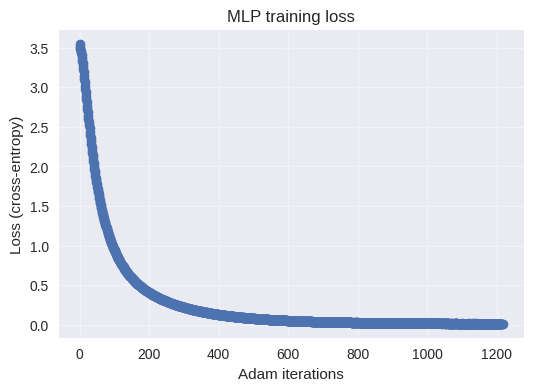

In [21]:
plt.figure(figsize=(6, 4))
plt.plot(localizer.encoder_.loss_curve_, marker='o')  # loss recorded by scikit-learn
plt.title("MLP training loss")
plt.xlabel("Adam iterations")
plt.ylabel("Loss (cross-entropy)")
plt.grid(True, alpha=0.4)
plt.show()


When the loss curve flattens the encoder has converged with the provided hyper-parameters. Otherwise you would adjust `learning_rate_init`, `alpha`, or `max_iter`.

## Phase 4 - Select a sample to inspect

### Train/test split note
The CLI pipeline (Phase 5) uses `train_test_split(..., stratify=y)` with an 80/20 ratio. This notebook section does not re-train; it reuses the entire dataset to illustrate preprocessing. Refer to the CLI or the CI smoke tests for the actual training/evaluation split.

In [22]:
# Define the grid cell (and optionally the campaign) we want to inspect.
TARGET_CELL = '1_4'      # change this to inspect another location
CAMPAIGN_NAME = None      # set to 'ddeuxmetres' or 'dquatremetres' to filter a campaign

subset = df[df['grid_cell'] == TARGET_CELL]
if CAMPAIGN_NAME:
    subset = subset[subset['campaign'] == CAMPAIGN_NAME]
if subset.empty:
    raise ValueError(f"No sample found for {TARGET_CELL} (campaign={CAMPAIGN_NAME}).")

# Random but reproducible pick thanks to random_state.
sample = subset.sample(1, random_state=7)
sample_features = sample[FEATURE_COLUMNS]
sample_meta = sample[['grid_cell', 'grid_x', 'grid_y', 'coord_x_m', 'coord_y_m', 'campaign']]

display(Markdown(
    f"### Selected sample: cell `{sample_meta.iloc[0]['grid_cell']}` (campaign `{sample_meta.iloc[0]['campaign']}`)"
))
display(sample_features)
display(sample_meta)


### Selected sample: cell `1_4` (campaign `ddeuxmetres`)

,Signal,Noise,signal_A1,signal_A2,signal_A3
338,-36,-95,-37,-44,-57


,grid_cell,grid_x,grid_y,coord_x_m,coord_y_m,campaign
338,1_4,1,4,1.125,0.45,ddeuxmetres


This cell selects the sample to analyze (`TARGET_CELL`) and produces two frames:
- `sample_features`: the five RSSI features passed to the model,
- router distance is kept only as metadata and excluded from the input space,
- `sample_meta`: grid indices, physical coordinates and campaign metadata used for validation.

### 4.1 - Standardization (centering / scaling)

In [23]:
# The scaler stores the training-set mean and standard deviation for each feature.
scaler = localizer.scaler_
raw_vec = sample_features.to_numpy()
scaled_vec = scaler.transform(raw_vec)

scaling_table = pd.DataFrame(
    {
        'feature': FEATURE_COLUMNS,
        'raw_value': raw_vec.flatten(),
        'training_mean': scaler.mean_,
        'training_std': scaler.scale_,
        'standardized_value': scaled_vec.flatten(),
    }
)
display(scaling_table)


,feature,raw_value,training_mean,training_std,standardized_value
0,Signal,-36,-35.570588,4.877863,-0.088033
1,Noise,-95,-95.000000,1.000000,0.000000
2,signal_A1,-37,-40.864706,6.363101,0.607362
3,signal_A2,-44,-40.696324,5.092929,-0.648679
4,signal_A3,-57,-43.472794,6.261636,-2.160331


`StandardScaler` enforces zero mean and unit variance for every feature. Without this normalization `Signal` could dominate the MLP gradients and the Euclidean distance used by L-KNN; scaling balances every RSSI feature.

### 4.2 - Physical location of the sample

In [24]:

coord_text = (
    f"Physical coordinates (m): x = {sample_meta.iloc[0]['coord_x_m']:.3f}, y = {sample_meta.iloc[0]['coord_y_m']:.3f}<br>"
    f"Grid index: (grid_x={sample_meta.iloc[0]['grid_x']}, grid_y={sample_meta.iloc[0]['grid_y']})"
)
display(Markdown(coord_text))


Physical coordinates (m): x = 1.125, y = 0.450<br>Grid index: (grid_x=1, grid_y=4)

Physical coordinates (meters) are also used when computing the Euclidean localization error `error_m = ||coord_true - coord_pred||`. The values correspond to the center of the instrumented cell.

### 4.3 - Propagate through the neural network

In [25]:

# Pass through every MLP layer to inspect how the sample is transformed.
activations = []
activation = scaled_vec
weight_count = len(localizer.encoder_.coefs_)
for idx, (weights, bias) in enumerate(zip(localizer.encoder_.coefs_, localizer.encoder_.intercepts_)):
    linear = activation @ weights + bias  # linear transformation of the current layer
    is_output = idx == weight_count - 1
    layer_name = 'output_logits' if is_output else f'hidden_{idx+1}'
    if not is_output:
        activation = _apply_activation(linear, localizer.encoder_.activation)
    else:
        activation = linear
    activations.append(
        {
            'layer': layer_name,
            'units': linear.shape[1],
            'min': float(activation.min()),
            'max': float(activation.max()),
            'preview_first5': np.round(activation[0, :5], 4).tolist(),
        }
    )

display(pd.DataFrame(activations))


,layer,units,min,max,preview_first5
0,hidden_1,64,0.000000,5.838726,"[0.0, 0.1401, 0.866, 1.7287, 0.0]"
1,hidden_2,32,0.000000,47.884741,"[0.0, 23.1477, 4.615, 0.0, 0.0]"
2,output_logits,34,-246.543089,42.782682,"[9.3904, -108.9129, -114.0833, -84.0627, -56.6..."


Each hidden layer applies a linear transformation followed by the activation (`ReLU`). The min/max columns make it easy to check that the activations are not saturated. The embedding consumed by L-KNN is simply the last hidden layer (32 values).

In [26]:

embedding = localizer.transform(sample_features)
print(f"Taille de l'embedding : {embedding.shape}")
embedding_df = pd.DataFrame(embedding, columns=[f"e{i}" for i in range(embedding.shape[1])])
display(embedding_df.round(4))


Taille de l'embedding : (1, 32)


,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9,...,e22,e23,e24,e25,e26,e27,e28,e29,e30,e31
0,0.0,23.1477,4.615,0.0,0.0,24.2237,0.0,0.0,30.1777,0.0,...,22.4383,7.0328,0.0,16.1811,0.0,0.0,0.0,0.0,0.0,29.25


The 32-component vector (`e0..e31`) is the input to the L-KNN. Cells that are close in the physical grid should produce embeddings that are close in this space; otherwise the neighbor search would be unstable.

Note : `neighbor_i_embedding_distance` est une distance dans l'espace latent du MLP (pas une distance physique) et est distincte de la distance routeur (2 m / 4 m) prédite par la tête LogReg.

## Phase 5 - L-KNN decision

### 5.0 - Heatmap of average RSSI
Before analyzing a specific sample we plot the mean `Signal` per cell to ensure the spatial gradient still reflects the router placement.

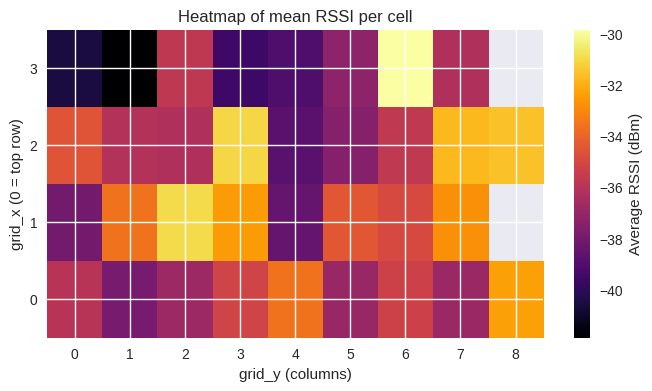

In [27]:
mean_signal = df.pivot_table(index='grid_x', columns='grid_y', values='Signal', aggfunc='mean')
plt.figure(figsize=(8, 4))
plt.imshow(mean_signal.sort_index(ascending=False), cmap='inferno', aspect='auto')
plt.colorbar(label='Average RSSI (dBm)')
plt.title('Heatmap of mean RSSI per cell')
plt.xlabel('grid_y (columns)')
plt.ylabel('grid_x (0 = top row)')
plt.xticks(range(mean_signal.shape[1]), mean_signal.columns)
plt.yticks(range(mean_signal.shape[0]), sorted(mean_signal.index, reverse=True))
plt.show()


In [28]:
# Retrieve the cell probabilities, final prediction, and the K nearest neighbors.
y_proba = localizer.predict_proba(sample_features)
y_pred = localizer.predict(sample_features)
neighbor_dist, neighbor_cells = localizer.explain(sample_features, top_k=5)

print(f"Predicted cell: {y_pred[0]} | max confidence: {y_proba.max():.4f}")

neighbor_df = pd.DataFrame(
    {
        'rank': np.arange(1, neighbor_cells.shape[1] + 1),
        'cell': neighbor_cells[0],
        'distance_embedding': neighbor_dist[0],
    }
)
neighbor_df = neighbor_df.join(cell_lookup, on='cell')
display(neighbor_df)


Predicted cell: 1_4 | max confidence: 1.0000


,rank,cell,distance_embedding,grid_x,grid_y,coord_x_m,coord_y_m,campaign
0,1,1_4,0.000000e+00,1,4,1.125,0.45,ddeuxmetres
1,2,1_4,9.536743e-07,1,4,1.125,0.45,ddeuxmetres
2,3,1_4,9.536743e-07,1,4,1.125,0.45,ddeuxmetres
3,4,1_4,9.536743e-07,1,4,1.125,0.45,ddeuxmetres
4,5,1_4,9.536743e-07,1,4,1.125,0.45,ddeuxmetres


`neighbor_df` lists the `K` reference cells sorted by Euclidean distance in the latent space. It doubles as an explainability artifact: you know exactly which historical fingerprints contributed to the final decision.

### Recap: Step 4 – Local KNN inference
Once the MLP encoder produces embeddings for the selected sample, the L-KNN searches the training embeddings, retrieves the K nearest neighbors, and votes the cell ID. The tables and plots below expose that neighborhood to explain the prediction.

### 5.1 - Histogram of neighbor distances
Each bar corresponds to one of the `K` neighbors returned by L-KNN. We label the x-axis with the neighbor rank so repeated cell names do not overlap.

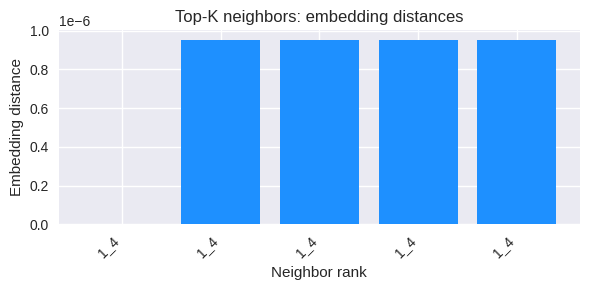

In [29]:
plt.figure(figsize=(6, 3))
plt.bar(neighbor_df['rank'], neighbor_df['distance_embedding'], color='dodgerblue')
plt.xticks(neighbor_df['rank'], neighbor_df['cell'], rotation=45, ha='right')
plt.xlabel('Neighbor rank')
plt.ylabel('Embedding distance')
plt.title('Top-K neighbors: embedding distances')
plt.tight_layout()
plt.show()


### 5.2 - Neighbor vote contributions
Distances are converted to weights (`1/distance`) to visualize how much each neighbor contributes to the L-KNN vote. The weights sum to 1.

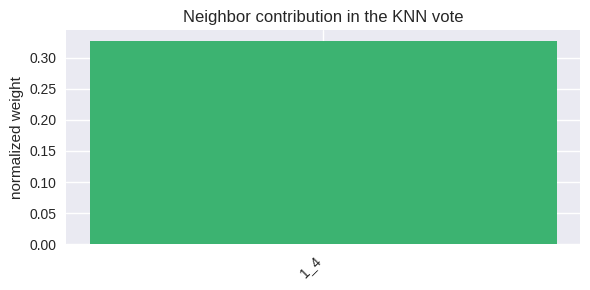

In [30]:
weights = 1 / (neighbor_df['distance_embedding'] + 1e-6)
weights = weights / weights.sum()
plt.figure(figsize=(6, 3))
plt.bar(neighbor_df['cell'], weights, color='mediumseagreen')
plt.xticks(rotation=45, ha='right')
plt.ylabel('normalized weight')
plt.title('Neighbor contribution in the KNN vote')
plt.tight_layout()
plt.show()


### 5.3 - Project neighbors on the board picture

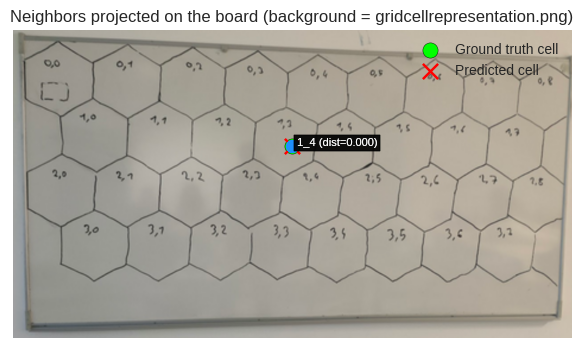

In [31]:

if GRID_IMAGE_PATH.exists():
    img = plt.imread(GRID_IMAGE_PATH)  # background picture of the magnetic board
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.imshow(img)

    def cell_to_pixels(cell_name: str):
        """Map a cell identifier to pixel coordinates on the image."""
        entry = cell_lookup.loc[cell_name]
        x_norm = entry['coord_x_m'] / GRID_WIDTH_M
        y_norm = entry['coord_y_m'] / GRID_HEIGHT_M
        px = x_norm * img.shape[1]
        py = y_norm * img.shape[0]
        return px, py

    # Actual vs predicted position of the inspected sample.
    true_px, true_py = cell_to_pixels(sample_meta.iloc[0]['grid_cell'])
    pred_px, pred_py = cell_to_pixels(y_pred[0])

    ax.scatter([true_px], [true_py], c='lime', s=120, marker='o', edgecolors='black', label='Ground truth cell')
    ax.scatter([pred_px], [pred_py], c='red', s=120, marker='x', label='Predicted cell')

    # Visualize the K neighbors that influenced the vote.
    for _, row in neighbor_df.iterrows():
        px, py = cell_to_pixels(row['cell'])
        ax.scatter(px, py, c='dodgerblue', s=80, alpha=0.7)
        label_txt = f"{row['cell']} (dist={row['distance_embedding']:.3f})"
        ax.text(
            px + 10,
            py,
            label_txt,
            color='white',
            fontsize=8,
            bbox=dict(facecolor='black', alpha=0.4, pad=2),
        )

    ax.set_title('Neighbors projected on the board (background = gridcellrepresentation.png)')
    ax.axis('off')
    ax.legend(loc='upper right')
    plt.show()
else:
    print("Image lesgridcells.png missing: overlay cannot be displayed.")


### 5.4 - Confusion matrix and reliability curve
- The confusion matrix (saved by `localization.pipeline`) highlights cells that are systematically confused.
- The reliability curve plots average model confidence vs observed accuracy to validate probability calibration.
- The bar chart shows how confidence scores are distributed across all measurements.
- `confusion_cell_distance_with_logreg.png` affiche la matrice pour le couple (cellule, distance routeur prédite) afin de vérifier que la bonne distance de campagne est identifiée.- `confusion_cell_distance_without_logreg.png` compare la même matrice (cellule + distance) avec une baseline simple: distance = mode observée pour la cellule prédite.


### Confusion matrix (cells)

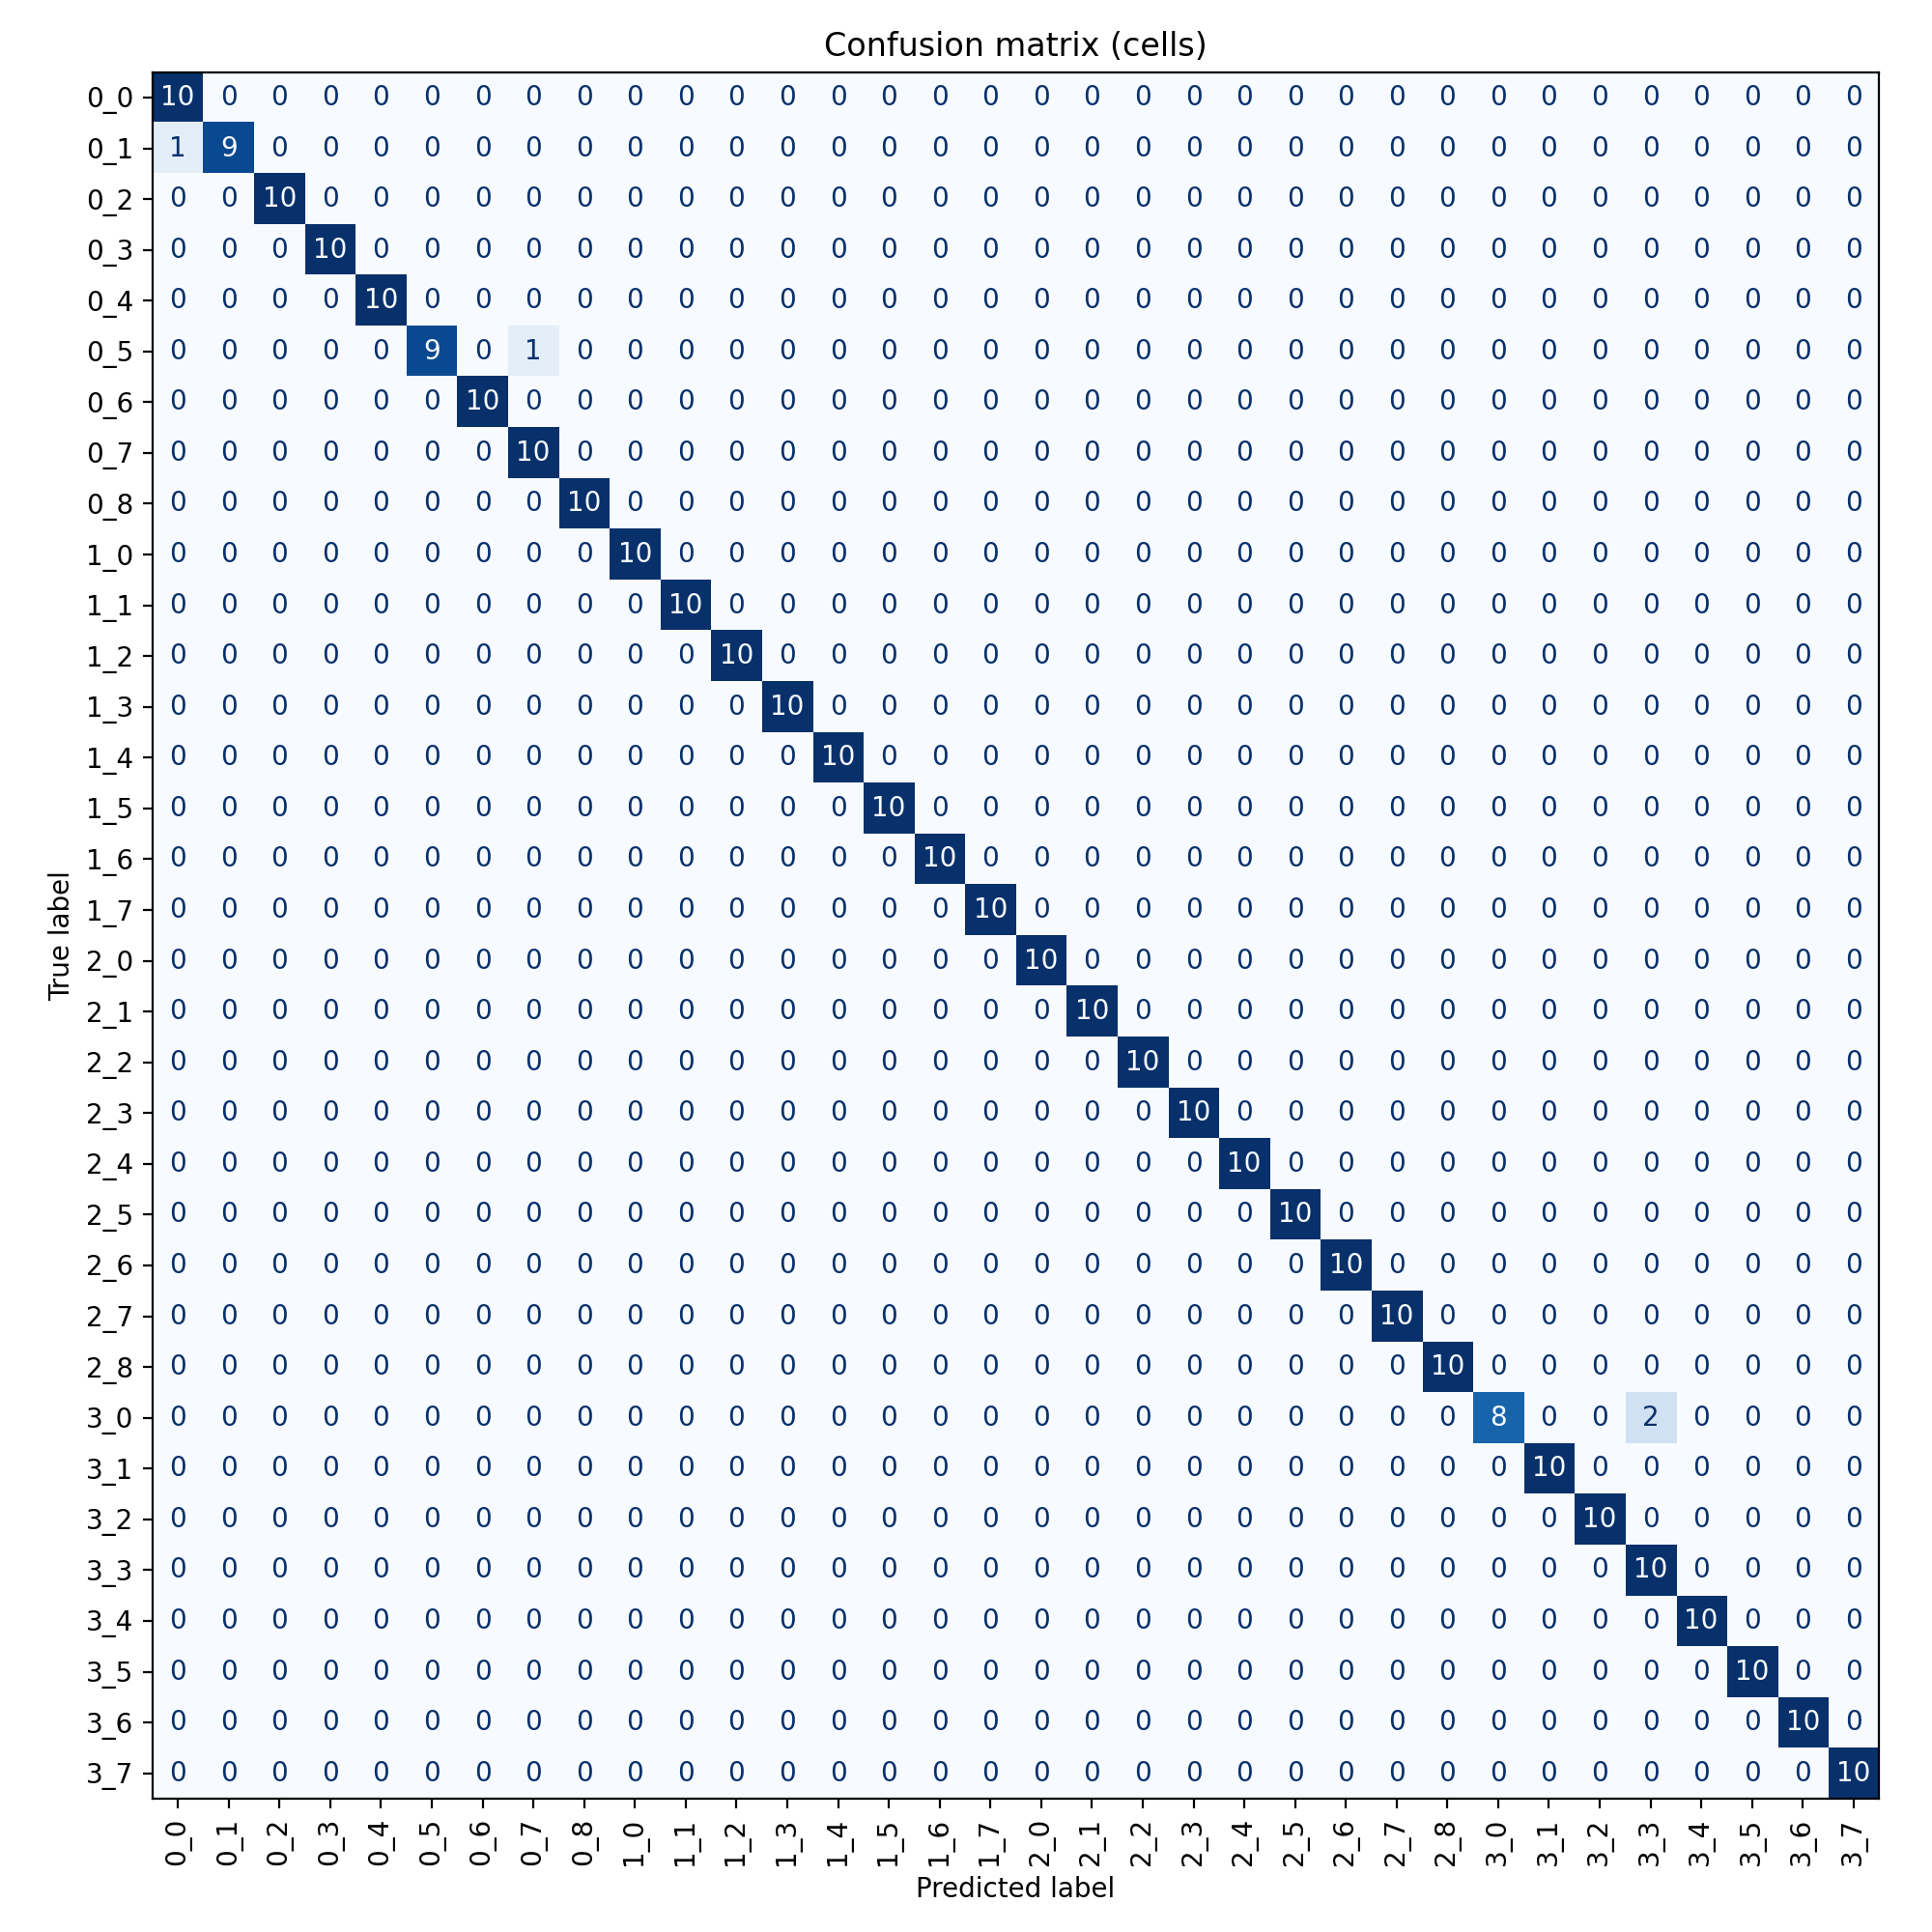

### Confusion matrix (cell + router distance, LogReg head)

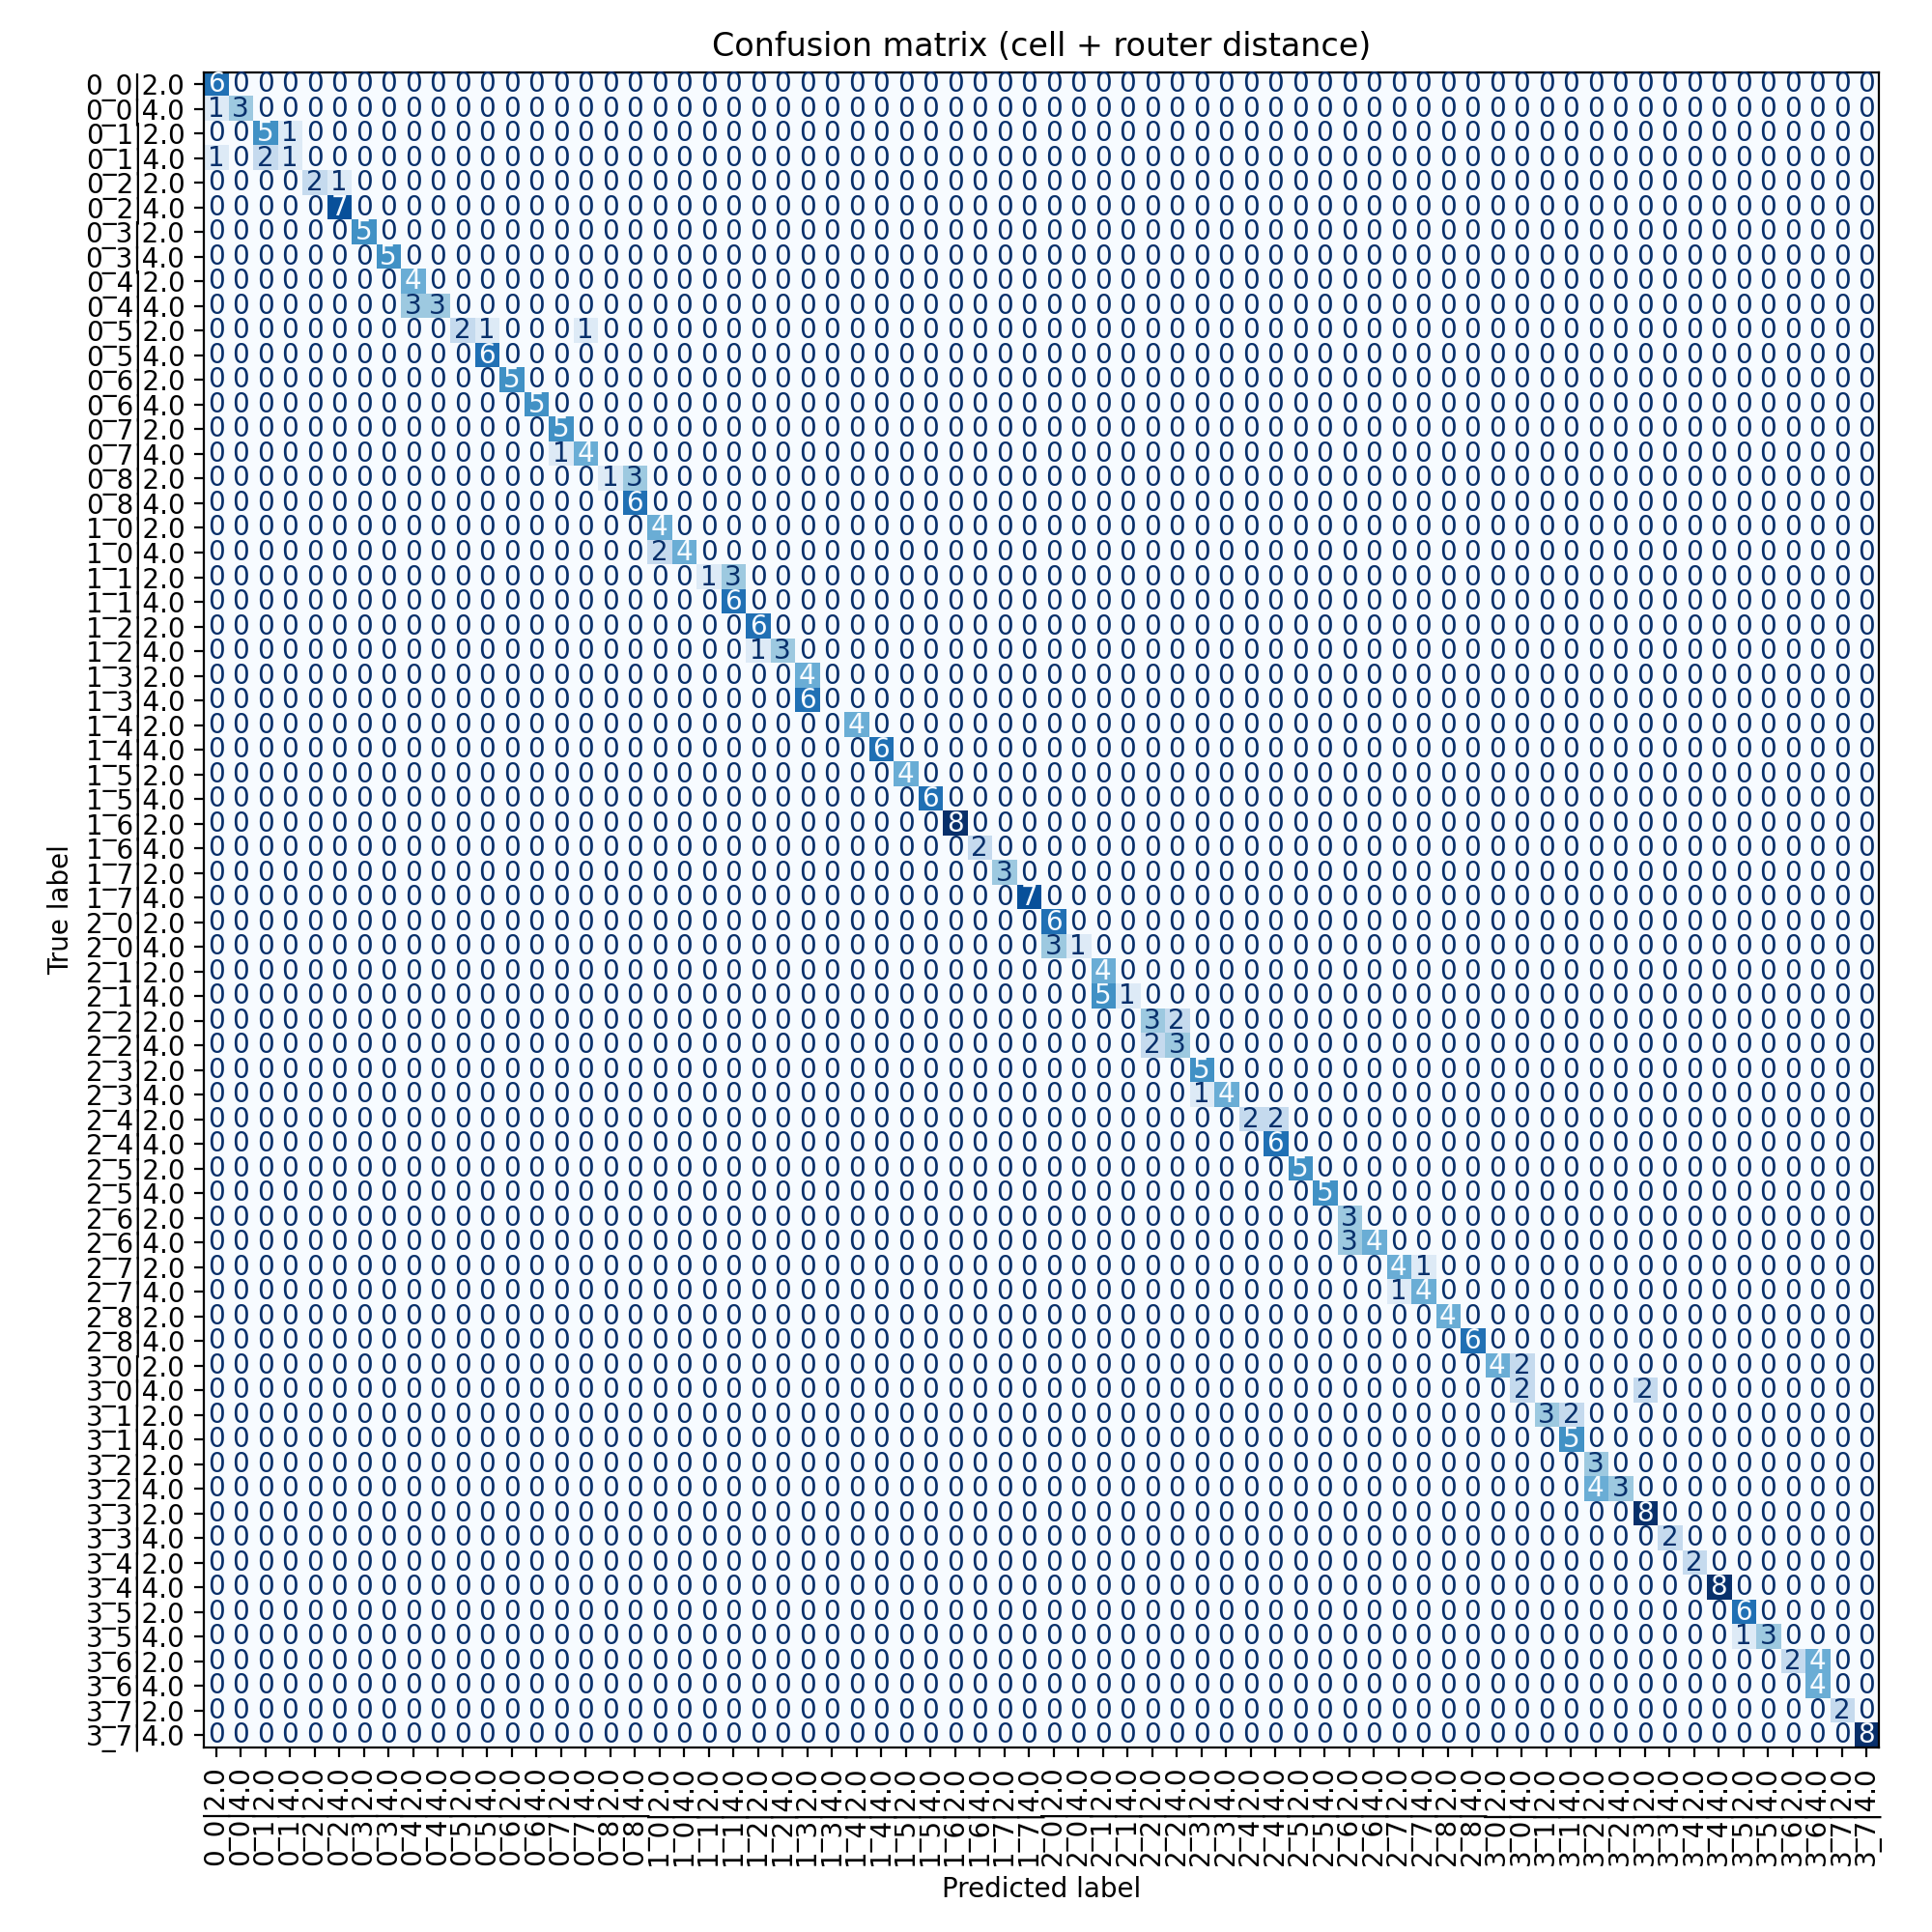

### Confusion matrix (cell + router distance, baseline mode per cell)

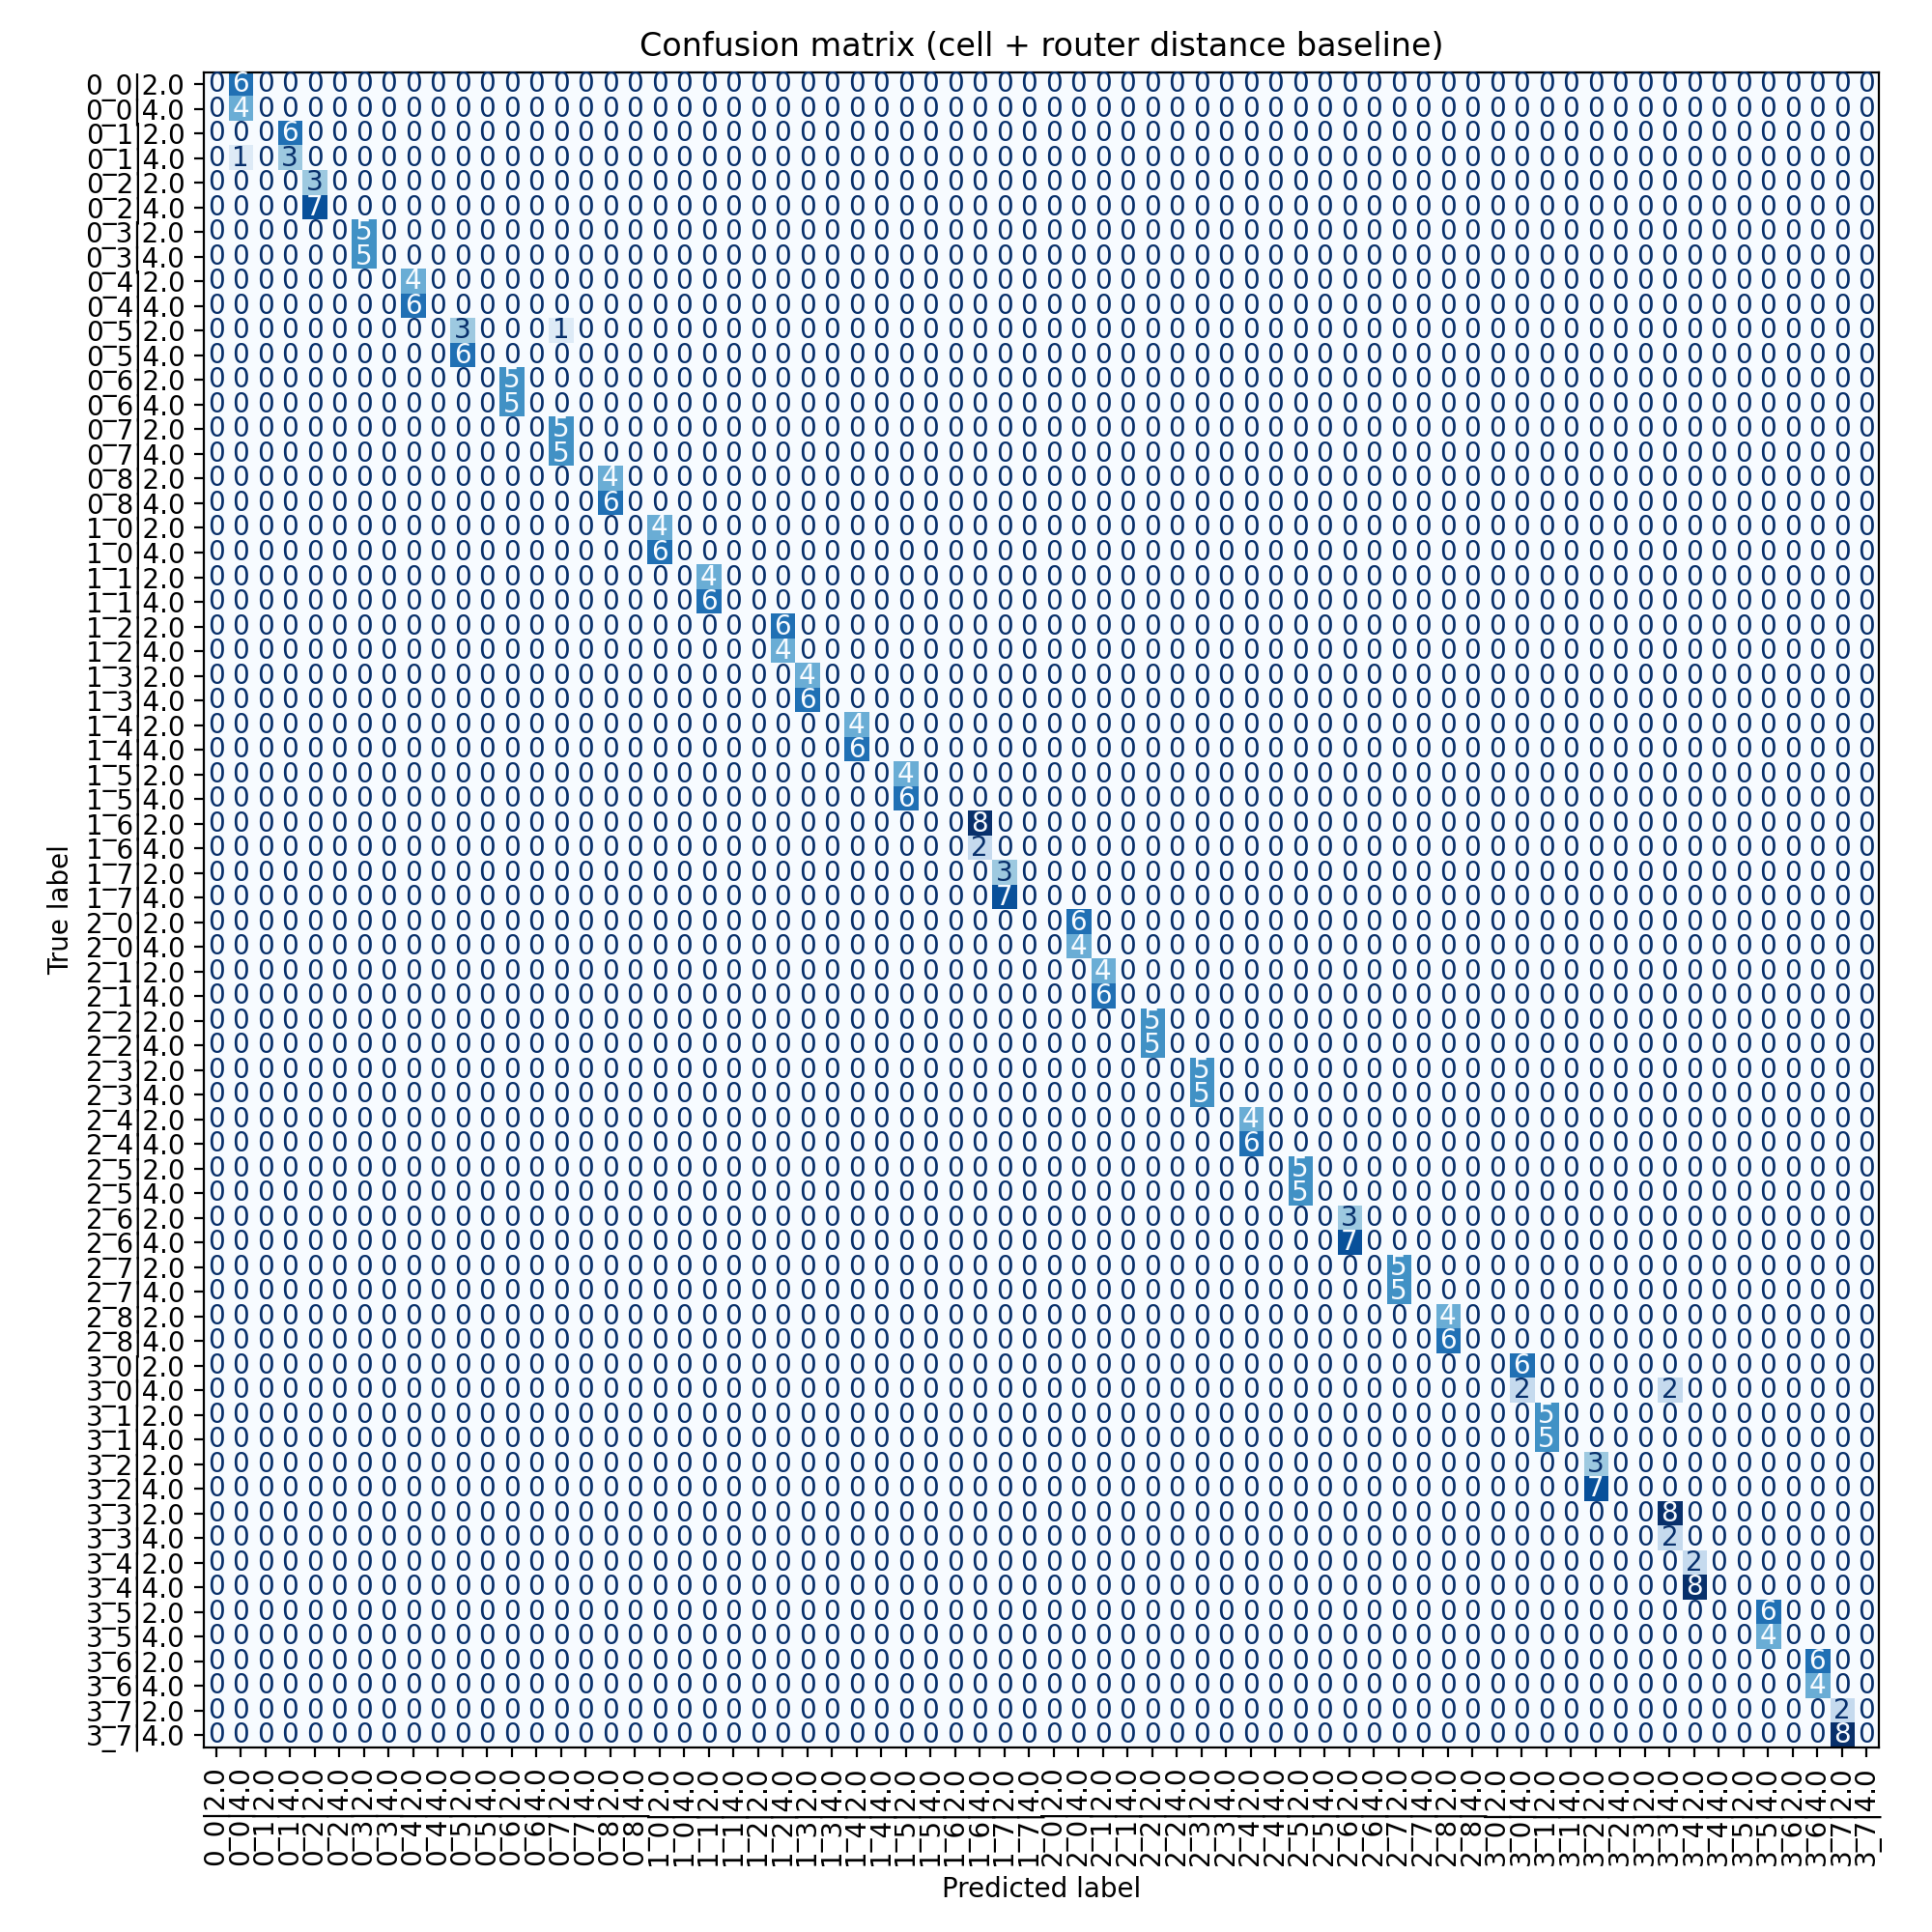

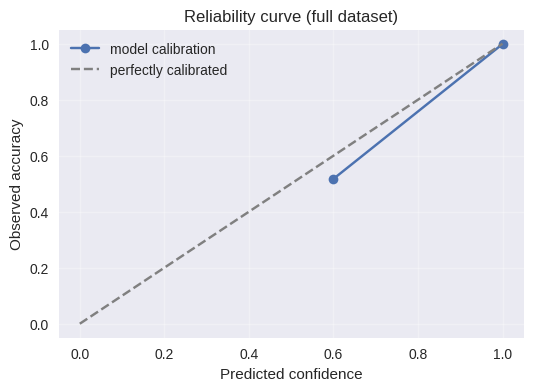

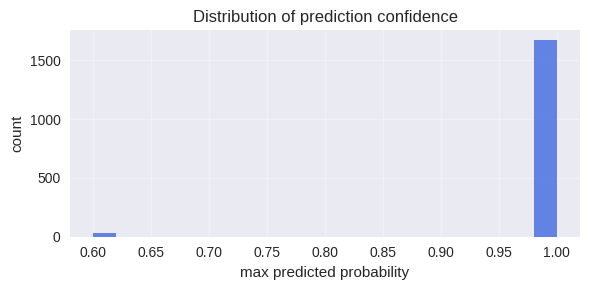

In [33]:
# Display the confusion matrix generated by the training pipeline
confusion_path = REPORTS_DIR / 'confusion_matrix.png'
confusion_combo_logreg = REPORTS_DIR / 'confusion_cell_distance_with_logreg.png'
confusion_combo_baseline = REPORTS_DIR / 'confusion_cell_distance_without_logreg.png'

for name, path in [
    ("Confusion matrix (cells)", confusion_path),
    ("Confusion matrix (cell + router distance, LogReg head)", confusion_combo_logreg),
    ("Confusion matrix (cell + router distance, baseline mode per cell)", confusion_combo_baseline),
]:
    if path.exists():
        display(Markdown(f"### {name}"))
        display(Image(filename=path))
    else:
        print(f"{path.name} missing: rerun localization.pipeline to regenerate it.")

# Print router-distance accuracies from latest_metrics.json if available
metrics_path = REPORTS_DIR / 'latest_metrics.json'
if metrics_path.exists():
    try:
        import json as _json
        m = _json.loads(metrics_path.read_text())
        acc = m.get('router_distance_accuracy')
        acc_base = m.get('router_distance_accuracy_baseline')
        if acc is not None and acc_base is not None:
            print(f"Router-distance accuracy -> LogReg head: {acc:.3f} | baseline (mode per cell): {acc_base:.3f}")
    except Exception as exc:
        print(f"Warning: unable to read metrics: {exc}")

# Reliability curve on the entire dataset
all_probs = localizer.predict_proba(df[FEATURE_COLUMNS])
all_preds = localizer.predict(df[FEATURE_COLUMNS])
true_cells = df['grid_cell'].to_numpy()

from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(
    (all_preds == true_cells).astype(int), all_probs.max(axis=1), n_bins=10
)
plt.figure(figsize=(6, 4))
plt.plot(prob_pred, prob_true, marker='o', label='model calibration')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='perfectly calibrated')
plt.xlabel('Predicted confidence')
plt.ylabel('Observed accuracy')
plt.title('Reliability curve (full dataset)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Histogram of confidence scores
plt.figure(figsize=(6, 3))
plt.hist(all_probs.max(axis=1), bins=20, color='royalblue', alpha=0.8)
plt.xlabel('max predicted probability')
plt.ylabel('count')
plt.title('Distribution of prediction confidence')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Recap: Step 5 – Evaluation metrics
The CLI pipeline and CI smoke tests compute accuracy, mean distance error, ROC AUC, and confidence calibration on the stratified test set. The reliability/ confusion outputs displayed here are the same artifacts, reproduced so you can verify that the model still meets the expected precision goals.

This figure brings everything together: green = ground truth cell, red = predicted cell, blue markers = the neighbor cells consulted by the L-KNN.

## Next steps
- Modify `TARGET_CELL` / `CAMPAIGN_NAME` to validate other positions or router distances.
- Add new measurement campaigns (different router heights, obstacles, etc.) and re-run the notebook to stress the embeddings.



## D005 / E101 – variantes salle-agnostique et salle-aware
Nous ajoutons trois scénarios complémentaires basés sur les campagnes multi-salles (en excluant `circulaire`) :
- NN + L-KNN sans feature de salle (leave-one-room-out) pour évaluer la généralisation.
- NN + L-KNN avec la salle encodée en one-hot (cas où la salle est connue à l'inférence).
- Une tête Logistic Regression pour prédire la distance routeur (2/3/4/5 m) à partir de l'embedding.


In [ ]:

from localization.embedding_knn import EmbeddingKnnConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

# Campagnes non circulaires par salle.
ROOM_CAMPAIGNS = {
    "D005": [
        PROJECT_ROOT / "data" / "D005" / "ddeuxmetres",
        PROJECT_ROOT / "data" / "D005" / "dquatremetres",
    ],
    "E101": [
        PROJECT_ROOT / "data" / "E101" / "dtroismetres",
        PROJECT_ROOT / "data" / "E101" / "dcinqmetres",
    ],
}

room_specs: list[tuple[str, CampaignSpec]] = []
missing = []
for room, folders in ROOM_CAMPAIGNS.items():
    for folder in folders:
        if folder.exists():
            room_specs.append((room, CampaignSpec(folder)))
        else:
            missing.append(folder)

if missing:
    print("Ignored missing folders:", [p.name for p in missing])

frames = []
for room, spec in room_specs:
    df_room = load_measurements([spec])
    df_room["room"] = room
    # Garder la granularité campagne + salle pour le debug.
    df_room["campaign"] = f"{room}/{spec.path.name}"
    frames.append(df_room)

if not frames:
    raise RuntimeError("Aucune campagne croisée trouvée. Vérifie les dossiers data/D005 et data/E101.")

cross_room_df = pd.concat(frames, ignore_index=True)
room_dummies = pd.get_dummies(cross_room_df["room"], prefix="room")
cross_room_df = pd.concat([cross_room_df, room_dummies], axis=1)
ROOM_OHE_COLUMNS = room_dummies.columns.tolist()

cell_lookup_all = (
    cross_room_df[["grid_cell", "grid_x", "grid_y", "coord_x_m", "coord_y_m"]]
    .drop_duplicates("grid_cell")
    .set_index("grid_cell")
)

print(
    f"Dataset cross-room: {len(cross_room_df)} lignes | salles={sorted(cross_room_df['room'].unique())} | "
    f"cells={cross_room_df['grid_cell'].nunique()} | distances={sorted(cross_room_df['router_distance_m'].unique())}"
)
display(cross_room_df.groupby(["room", "campaign", "router_distance_m"]).size())



### Helpers (features, métriques, tête distance)
Les helpers ci-dessous factorisent la construction des features (avec ou sans salle), 
le fit du NN+L-KNN et la tête Logistic Regression pour la distance routeur.


In [ ]:

def build_features(df, include_room: bool):
    base = df[FEATURE_COLUMNS]
    if not include_room:
        return base.to_numpy()
    extras = df[ROOM_OHE_COLUMNS]
    return pd.concat([base.reset_index(drop=True), extras.reset_index(drop=True)], axis=1).to_numpy()

def fit_nn_lknn(train_df, include_room: bool, **config_overrides):
    cfg_kwargs = {
        "hidden_layer_sizes": (64, 32),
        "k_neighbors": 5,
        "learning_rate_init": 1e-3,
        "alpha": 1e-4,
        "max_iter": 1200,
        "random_state": 7,
    }
    cfg_kwargs.update(config_overrides)
    cfg = EmbeddingKnnConfig(**cfg_kwargs)
    model = EmbeddingKnnLocalizer(config=cfg)
    model.fit(build_features(train_df, include_room), train_df["grid_cell"])
    return model

def localization_summary(test_df, y_pred):
    pred_meta = cell_lookup_all.loc[y_pred]
    true_coords = test_df[["coord_x_m", "coord_y_m"]].to_numpy()
    pred_coords = pred_meta[["coord_x_m", "coord_y_m"]].to_numpy()
    errors_m = np.linalg.norm(true_coords - pred_coords, axis=1)
    return {
        "cell_acc": float((y_pred == test_df["grid_cell"].to_numpy()).mean()),
        "mean_error_m": float(errors_m.mean()),
        "p90_error_m": float(np.percentile(errors_m, 90)),
    }

def train_distance_head(model, train_df, test_df, include_room: bool):
    train_emb = model.transform(build_features(train_df, include_room))
    test_emb = model.transform(build_features(test_df, include_room))
    distance_clf = LogisticRegression(max_iter=5000, solver="lbfgs")
    distance_clf.fit(train_emb, train_df["router_distance_m"])
    dist_pred = distance_clf.predict(test_emb)
    return distance_clf, float(accuracy_score(test_df["router_distance_m"], dist_pred))



### NN + L-KNN sans salle (leave-one-room-out) + tête distance
On entraîne sans feature `room` et on évalue en tenant une salle complète à l'écart
(simule une salle jamais vue). La tête LogReg distance est entraînée uniquement si toutes
les classes de distance présentes en test existent dans le train correspondant.


In [ ]:

room_agnostic_rows = []
for held_out_room in sorted(cross_room_df["room"].unique()):
    train_df = cross_room_df[cross_room_df["room"] != held_out_room]
    test_df = cross_room_df[cross_room_df["room"] == held_out_room]

    model_no_room = fit_nn_lknn(train_df, include_room=False)
    y_pred = model_no_room.predict(build_features(test_df, include_room=False))
    metrics = localization_summary(test_df, y_pred)

    # Distance head (only if all distances present in train to avoid unseen labels).
    dist_clf = None
    dist_acc = np.nan
    if set(test_df["router_distance_m"]).issubset(set(train_df["router_distance_m"])):
        dist_clf, dist_acc = train_distance_head(model_no_room, train_df, test_df, include_room=False)

    row = {"held_out_room": held_out_room, "n_test": len(test_df), **metrics, "router_distance_acc": dist_acc}
    room_agnostic_rows.append(row)

room_agnostic_results = pd.DataFrame(room_agnostic_rows)
room_agnostic_results



### NN + L-KNN avec salle connue (one-hot) + tête distance
Cas où la salle est fournie à l'inférence. On fait un split stratifié 80/20
qui mélange les salles mais inclut la colonne `room_*`.


In [ ]:

from tqdm.auto import tqdm

with tqdm(total=3, desc="Room-aware evaluation") as pbar:
    room_aware_train, room_aware_test = train_test_split(
        cross_room_df,
        test_size=0.2,
        random_state=21,
        stratify=cross_room_df["grid_cell"],
    )
    pbar.update(1)

    model_with_room = fit_nn_lknn(room_aware_train, include_room=True)
    y_pred_room = model_with_room.predict(build_features(room_aware_test, include_room=True))
    room_aware_metrics = localization_summary(room_aware_test, y_pred_room)
    pbar.update(1)

    _, room_distance_acc = train_distance_head(model_with_room, room_aware_train, room_aware_test, include_room=True)
    pbar.update(1)

print("Room-aware cell accuracy = {cell_acc:.3f}, mean error = {mean_error_m:.3f} m, p90 = {p90_error_m:.3f} m".format(**room_aware_metrics))
print(f"Room-aware router distance accuracy (LogReg head): {room_distance_acc:.3f}")



### LogReg dédiée à la distance routeur (embedding NN sans salle)
On sépare 80/20 stratifié sur la distance, encode en embedding avec le modèle
sans salle, puis on entraîne une LogisticRegression multi-classes (2/3/4/5 m).


In [ ]:

distance_train, distance_test = train_test_split(
    cross_room_df,
    test_size=0.2,
    random_state=33,
    stratify=cross_room_df["router_distance_m"],
)

base_model_distance = fit_nn_lknn(distance_train, include_room=False, random_state=33)
train_emb = base_model_distance.transform(build_features(distance_train, include_room=False))
test_emb = base_model_distance.transform(build_features(distance_test, include_room=False))

distance_logreg = LogisticRegression(max_iter=5000, solver="lbfgs")
distance_logreg.fit(train_emb, distance_train["router_distance_m"])

dist_pred = distance_logreg.predict(test_emb)
dist_acc = accuracy_score(distance_test["router_distance_m"], dist_pred)
dist_proba = distance_logreg.predict_proba(test_emb)

print(f"Router distance accuracy (stratified split, room-agnostic embedding): {dist_acc:.3f}")
# Confusion normalisée par classe pour visualiser où ça coince.
dist_confusion = pd.crosstab(distance_test["router_distance_m"], dist_pred, normalize="index").round(3)
dist_confusion



### Lancer le benchmark complet (NN+L-KNN vs RF)
Ce bloc exécute `scripts/benchmark_models.py` : room-agnostic (leave-one-room-out), room-aware (salle connue),
tête LogReg distance et classif de salle. La sortie console affiche toutes les métriques.


In [ ]:

import subprocess
from pathlib import Path

BENCH_SCRIPT = PROJECT_ROOT / "scripts" / "benchmark_models.py"
print(f"Running benchmark script: {BENCH_SCRIPT}")
result = subprocess.run(["python", str(BENCH_SCRIPT)], capture_output=True, text=True)
print(result.stdout)
if result.stderr:
    print("[stderr]\n" + result.stderr)
if result.returncode != 0:
    raise RuntimeError(f"Benchmark failed with code {result.returncode}")

# Lister les matrices de confusion générées pour inspection rapide.
conf_dir = PROJECT_ROOT / "reports" / "benchmarks"
if conf_dir.exists():
    print("\nConfusion matrices generated:")
    for csv_path in sorted(conf_dir.glob("confusion_*.csv")):
        print(" -", csv_path.relative_to(PROJECT_ROOT))
    # Aperçu du premier CSV
    first = next(conf_dir.glob("confusion_*.csv"), None)
    if first:
        import pandas as pd

        print(f"\nPreview of {first.name}:")
        display(pd.read_csv(first).head())
else:
    print("No confusion directory found. Did the benchmark run?")
